In [1]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt

In [4]:
dowjones_closing = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv")

In [7]:
dowjones = dowjones_closing['Close']

In [14]:
#Функция для оценнки стационарности ряда по Дики-Фуллеру
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')  
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    dfoutput['The maximized information criterion'] = dftest[5]
    print(dfoutput)

In [15]:
#Отрисовка временного ряда с тестом Дики-Фулерра
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

#### Исходные данные

Results of Dickey-Fuller Test:
Test Statistic                           -1.314625
p-value                                   0.622455
Lags Used                                 0.000000
Number of Observations Used             161.000000
Critical Value (1%)                      -3.471633
Critical Value (5%)                      -2.879665
Critical Value (10%)                     -2.576434
The maximized information criterion    1303.505871
dtype: float64


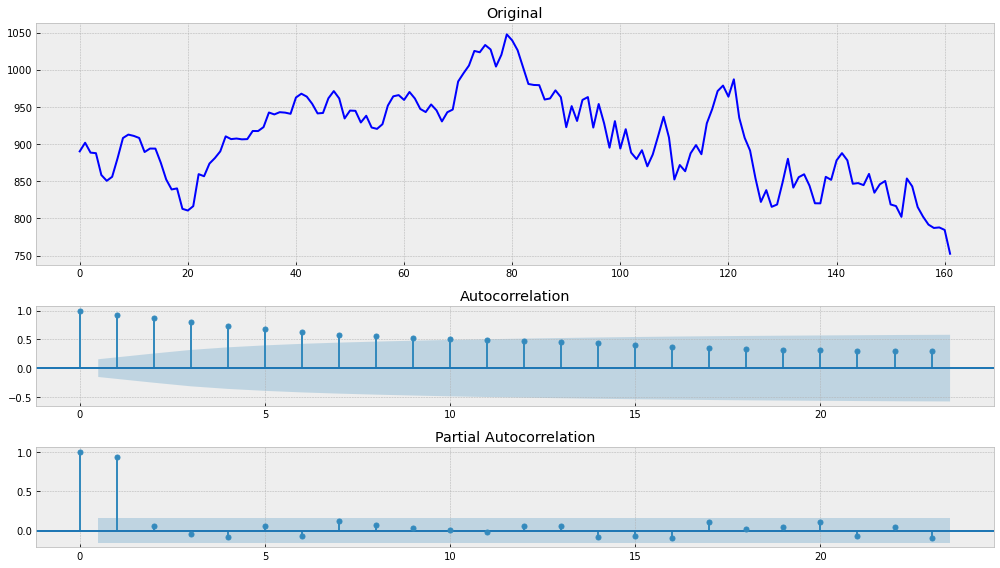

In [16]:
tsplot(dowjones)

#### Применяем модель ARIMA

ARIMA - естественное расширение модели ARMA. Как мы уже хорошо знаем - многие временные ряды не стационарны, но они могут такими стать в результате операции дифференцирования. В модели ARIMA "дифференцирование" (в количестве d-раз) вносится в саму модель


$\delta^p y_t = c + \sum_{i=1}^p a_i \delta^d y_{t-i} + \sum_{j=1}^q b_j \epsilon_{t-j} + \epsilon_t$

In [24]:
import warnings
warnings.simplefilter(action='ignore', category = FutureWarning)
warnings.filterwarnings('ignore')

aic: 1416.276699795694, order: (2, 2, 3)
Results of Dickey-Fuller Test:
Test Statistic                        -1.184569e+01
p-value                                7.408781e-22
Lags Used                              0.000000e+00
Number of Observations Used            1.590000e+02
Critical Value (1%)                   -3.472161e+00
Critical Value (5%)                   -2.879895e+00
Critical Value (10%)                  -2.576557e+00
The maximized information criterion    1.277397e+03
dtype: float64


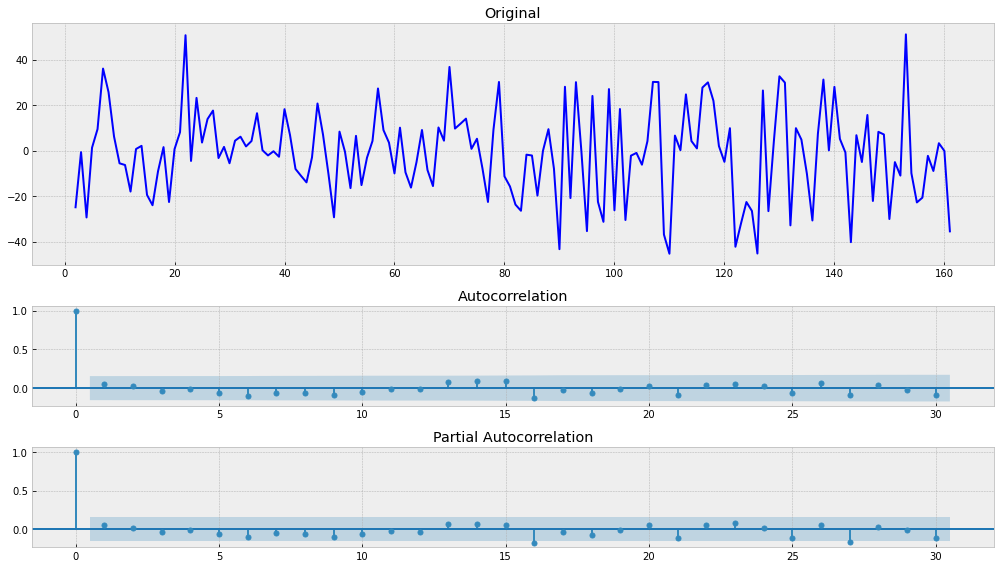

In [25]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(dowjones, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue

print(f'aic: {best_aic}, order: {best_order}')

tsplot(best_mdl.resid, lags=30)

#### Таким образом, модель подобрала оптимальные параметры такие: порядок авторегрессии 2, дифференцирование 2, и 3 компонента в скользящей средней

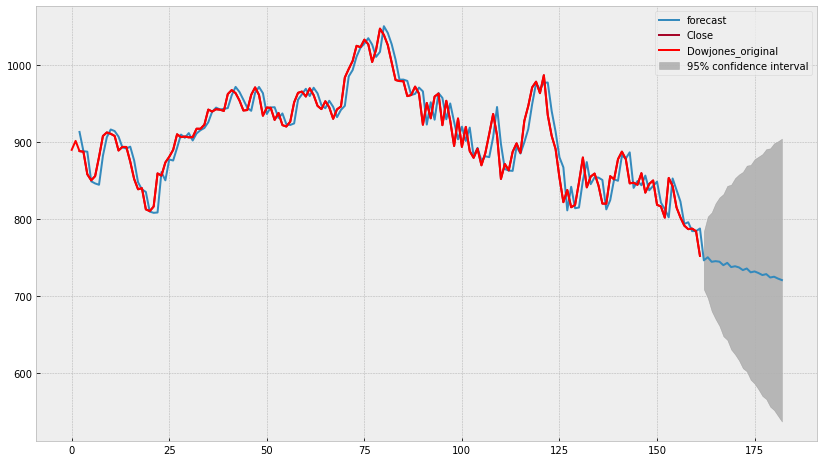

In [46]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    best_mdl.plot_predict(2, len(dowjones)+20, ax=ax, alpha = 0.05)
    plt.plot(dowjones, color='red', label='Dowjones_original')
    plt.legend()
    plt.show()

#### Построим предсказание при помощи классического ML на примере модели случайного леса

In [144]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(random_state = 2)
le = LabelEncoder()
dj_tree = dowjones_closing

In [145]:
#перекодируем недели
dj_tree['week_encode'] = le.fit_transform(dj_tree['Week'])

In [146]:
#разбивка на тест и трейн
X_train, X_test, y_train, y_test = train_test_split(dj_tree['week_encode'], dj_tree['Close'], test_size=0.3, random_state = 11)

In [147]:
#обучаем модель
rfr.fit(np.array(X_train).reshape(-1, 1), y_train)

RandomForestRegressor(random_state=2)

In [148]:
#смотрим качество, 0.9 модель вполне хорошо обучилась
rfr.score(np.array(X_test).reshape(-1, 1), y_test)

0.9033193703252855

In [149]:
#задаем значения для предсказаний
week_to_predict = np.arange(162, 200).reshape(-1,1)

In [159]:
#предсказываем, всё одинакого
prediction_rfr = rfr.predict(week_to_predict)
prediction_rfr

array([791.2415, 791.2415, 791.2415, 791.2415, 791.2415, 791.2415,
       791.2415, 791.2415, 791.2415, 791.2415, 791.2415, 791.2415,
       791.2415, 791.2415, 791.2415, 791.2415, 791.2415, 791.2415,
       791.2415, 791.2415, 791.2415, 791.2415, 791.2415, 791.2415,
       791.2415, 791.2415, 791.2415, 791.2415, 791.2415, 791.2415,
       791.2415, 791.2415, 791.2415, 791.2415, 791.2415, 791.2415,
       791.2415, 791.2415])

In [185]:
original_and_prediction_rfr = dj_tree['Close'].tolist() + list(prediction_rfr)

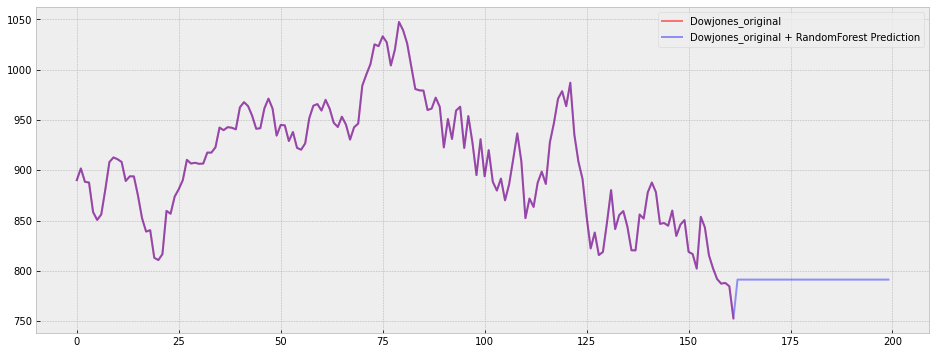

In [186]:
plt.style.use('bmh')
plt.figure(figsize = (16,6))
plt.plot(dowjones, label = 'Dowjones_original', alpha = 0.5, color = 'red')
plt.plot(original_and_prediction_rfr, label = 'Dowjones_original + RandomForest Prediction', alpha = 0.4, color = 'blue')
plt.legend()

#### Модель случайного леса поредсказала, что дальнейшие значения ряда будут все одинаковые

#### Проверим линейную модель

In [151]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [152]:
lr.fit(np.array(X_train).reshape(-1, 1), y_train)

LinearRegression()

In [187]:
#обучилась гораздо хуже
lr.score(np.array(X_test).reshape(-1, 1), y_test)

0.15908522301225225

In [188]:
prediction_lr = lr.predict(week_to_predict)
prediction_lr

array([881.24798602, 880.89298304, 880.53798007, 880.1829771 ,
       879.82797412, 879.47297115, 879.11796817, 878.7629652 ,
       878.40796223, 878.05295925, 877.69795628, 877.3429533 ,
       876.98795033, 876.63294736, 876.27794438, 875.92294141,
       875.56793843, 875.21293546, 874.85793249, 874.50292951,
       874.14792654, 873.79292356, 873.43792059, 873.08291762,
       872.72791464, 872.37291167, 872.0179087 , 871.66290572,
       871.30790275, 870.95289977, 870.5978968 , 870.24289383,
       869.88789085, 869.53288788, 869.1778849 , 868.82288193,
       868.46787896, 868.11287598])

In [189]:
original_and_prediction_lr = dj_tree['Close'].tolist() + list(prediction_lr)

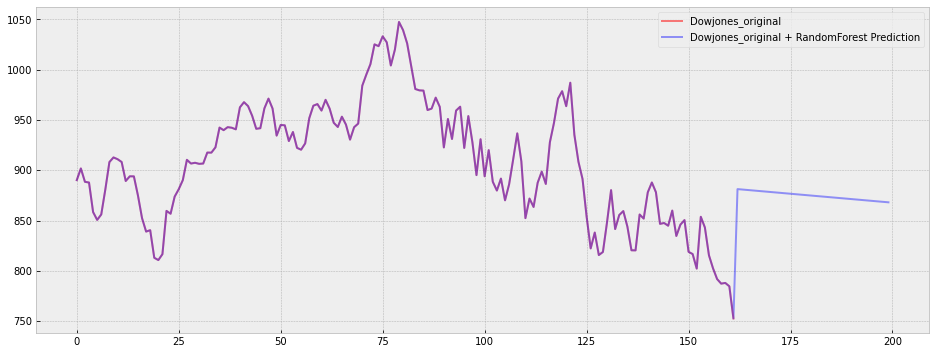

In [190]:
plt.style.use('bmh')
plt.figure(figsize = (16,6))
plt.plot(dowjones, label = 'Dowjones_original', alpha = 0.5, color = 'red')
plt.plot(original_and_prediction_lr, label = 'Dowjones_original + RandomForest Prediction', alpha = 0.4, color = 'blue')
plt.legend()